# Importing libraries and modules

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score

# Extracting the data

In [2]:
df = pd.read_csv(r'C:\Users\rtfol\Desktop\לימודים\שנה ב\סמסטר ב\מדע נתונים - תיאוריה ומעשה\vehicles.csv')
print(df.shape)
df.head()

(458213, 26)


,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


# Checking the info of the dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

In [4]:
null_columns = df.columns[df.isna().mean() > 0.4]
df = df.drop(null_columns, axis=1)

In [5]:
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('id', axis=1)
df = df.select_dtypes(include=[np.number])

# Checking NaN cells by % for each column left

In [6]:
df.isnull().sum().sort_values()*100/len(df)

price        0.000000
year         0.229151
lat          1.625445
long         1.625445
odometer    12.069278
dtype: float64

# Looking for outliers

There are outliers in price, year and odometer columns

In [7]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,price,year,odometer,lat,long
count,458213.000000,457163.000000,402910.000000,450765.000000,450765.000000
mean,40420.930696,2010.746067,101669.756941,38.531925,-94.375824
std,8194598.603665,8.868136,3228622.544962,5.857378,18.076225
min,0.000000,1900.000000,0.000000,-82.607549,-164.091797
25%,4900.000000,2008.000000,40877.000000,34.600000,-110.890427
50%,10995.000000,2013.000000,87641.000000,39.244500,-88.314889
75%,21495.000000,2016.000000,134000.000000,42.484503,-81.015022
max,3615215112.000000,2021.000000,2043755555.000000,82.049255,150.898969


# Setting the outliers to be reasonable

In [8]:
p_low = df['price'].quantile(0.1)
p_high = df['price'].quantile(0.9995)
df = df[(df['price'] < p_high) & (df['price'] > p_low)]

In [9]:
y_low = df['year'].quantile(0.026)
y_high = df['year'].quantile(1)
df = df[(df['year'] <= y_high) & (df['year'] > y_low)]

In [10]:
o_low = df['odometer'].quantile(0)
o_high = df['odometer'].quantile(0.99)
df = df[(df['odometer'] < o_high) & (df['odometer'] >= o_low)]

In [11]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,price,year,odometer,lat,long
count,354740.000000,354740.000000,354740.000000,352164.000000,352164.000000
mean,16935.890582,2011.858141,93614.059528,38.707977,-94.158520
std,13259.849201,5.513977,59526.883666,5.858462,17.984949
min,652.000000,1990.000000,0.000000,-81.702792,-164.091797
25%,6985.000000,2008.000000,42324.000000,34.917585,-108.572700
50%,13500.000000,2013.000000,90173.000000,39.491150,-87.980000
75%,23990.000000,2016.000000,135899.250000,42.587700,-80.989166
max,155995.000000,2021.000000,270278.000000,76.781734,94.163200


# Convert price from int64 to float64 data type

In [ ]:
df['price'] = df['price'].astype(np.float64)

# Getting rid of NaN values

In [12]:
df = df.dropna()
df = df.reset_index(drop=True)
df.isnull().sum().sort_values()*100/len(df)

price       0.0
year        0.0
odometer    0.0
lat         0.0
long        0.0
dtype: float64

In [13]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,price,year,odometer,lat,long
count,352164.000000,352164.000000,352164.000000,352164.000000,352164.000000
mean,16934.560327,2011.857004,93544.179629,38.707977,-94.158520
std,13267.180181,5.517638,59558.352153,5.858462,17.984949
min,652.000000,1990.000000,0.000000,-81.702792,-164.091797
25%,6977.000000,2008.000000,42215.000000,34.917585,-108.572700
50%,13500.000000,2013.000000,90000.000000,39.491150,-87.980000
75%,23990.000000,2016.000000,135889.000000,42.587700,-80.989166
max,155995.000000,2021.000000,270278.000000,76.781734,94.163200


# Plotting each column

price plot

<AxesSubplot:>

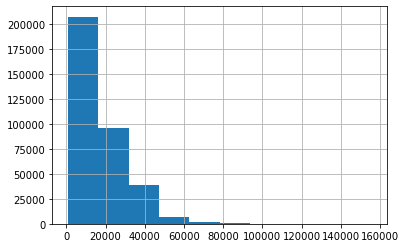

In [14]:
df.price.hist()

year plot

<AxesSubplot:>

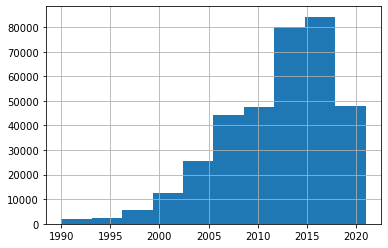

In [15]:
df.year.hist()

odometer plot

<AxesSubplot:>

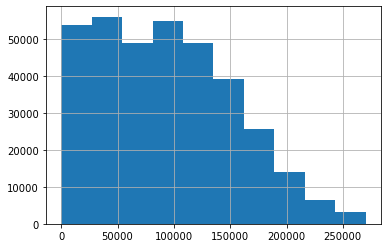

In [16]:
df.odometer.hist()

latitude plot

<AxesSubplot:>

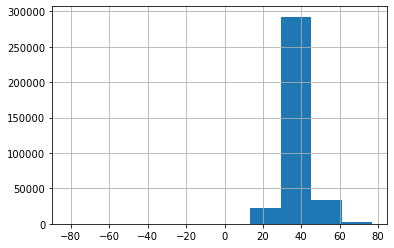

In [17]:
df.lat.hist()

longitude plot

<AxesSubplot:>

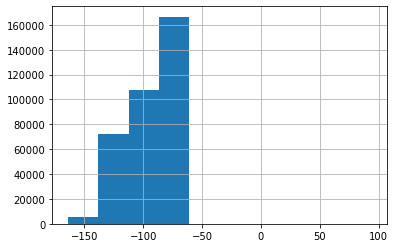

In [18]:
df.long.hist()

# Box plot for every column

<AxesSubplot:>

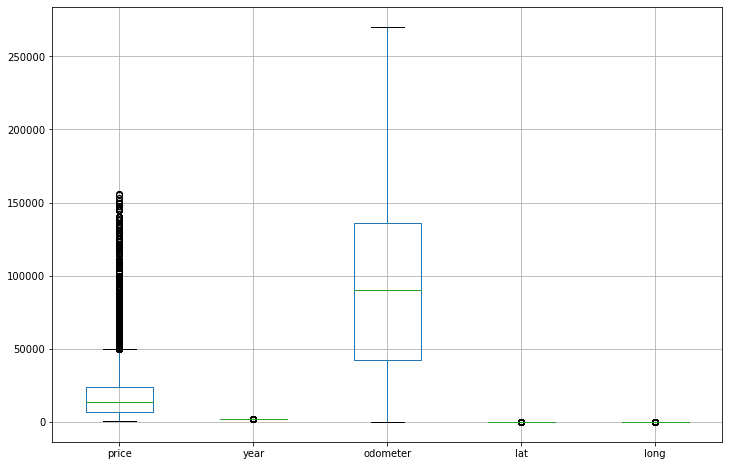

In [19]:
plt.figure(figsize=(12,8))
df.boxplot()

# Correlation Matrix

<AxesSubplot:>

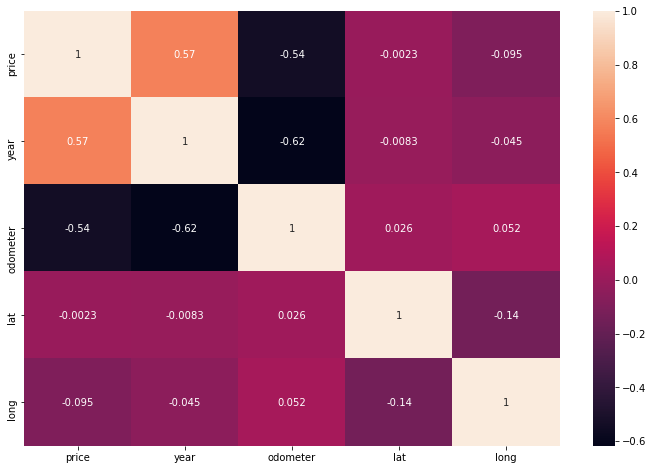

In [20]:
corrmatrix = df.corr()
plt.figure(figsize=(12,8))
sn.heatmap(corrmatrix, xticklabels=corrmatrix.columns, yticklabels=corrmatrix.columns, annot=True)

# Training and Prediction

In [21]:
X = df.drop('price',axis=1)
y = df.loc[:, 'price']
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=100)

# Linear Regression

HoldOut

In [37]:
model_ho_lr = LinearRegression()
model_ho_lr.fit(X_train, y_train)
y_pred_lr = model_ho_lr.predict(X_test)
result_ho_lr = model_ho_lr.score(X_train, y_train)
print('Accuracy: %.2f%%' % (result_ho_lr*100))

Accuracy: 38.58%


K-Fold

In [40]:
kfold_lr = KFold(n_splits=10, random_state=1)
model_kfold_lr = LinearRegression()
result_kfold_lr = cross_val_score(model_kfold_lr, X, y, cv=kfold_lr)
print('Accuracy: %.2f%%' % (result_kfold_lr.mean()*100.0))

C:\Users\rtfol\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Accuracy: 38.21%


LeaveOneOut

In [ ]:
loocv_lr = LeaveOneOut()
model_loocv_lr = LinearRegression()
result_loocv_lr = cross_val_score(model_loocv_lr, X, y, cv=loocv_lr)
print('Accuracy: %.2f%%' % (result_loocv_lr.mean()*100.0))

Mean Squared Error

In [41]:
print('Mean Squared Error:', mean_squared_error(y_test,y_pred_lr))

Mean Squared Error: 107781780.01298839


# KNN

HoldOut

In [45]:
model_knn_ho = KNeighborsClassifier(n_neighbors=5)
model_knn_ho.fit(X_train, y_train)
y_pred_knn = model_ho_lr.predict(X_test)
result_knn_ho = model_knn_ho.score(X_train, y_train)
print('Accuracy: %.2f%%' % (result_knn_ho*100))

Accuracy: 42.90%


K-Fold

In [42]:
kfold_knn = KFold(n_splits=10, random_state=1)
model_kfold_knn = KNeighborsClassifier(n_neighbors=5)
result_kfold_knn = cross_val_score(model_kfold_knn, X, y, cv=kfold_knn)
print('Accuracy: %.2f%%' % (result_kfold_knn.mean()*100.0))

C:\Users\rtfol\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Accuracy: 14.17%


LeaveOneOut